## <center> Análisis de la pérdida de clientes de telecomunicaciones y optimización de costes

## Contexto
Este dataset simula clientes de una empresa de telecomunicaciones. El objetivo es predecir si un cliente abandonará el servicio (`Churn`) y generar insights relacionados a los **costos de pérdida de clientes**, útil para el área financiera (CFO). 

## Columnas
- `customerID`: ID único de cliente  
- `gender`: Género del cliente (Male/Female)  
- `SeniorCitizen`: Cliente mayor de 65 años (0 = no, 1 = sí)  
- `Partner`: Si tiene pareja (Yes/No)  
- `Dependents`: Si tiene dependientes (Yes/No)  
- `tenure`: Meses como cliente  
- `PhoneService`: Servicio de teléfono (Yes/No)  
- `MultipleLines`: Líneas múltiples (Yes/No/No phone service)  
- `InternetService`: Tipo de internet (DSL/Fiber optic/None)  
- `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`: Servicios adicionales contratados (Yes/No)  
- `Contract`: Tipo de contrato (Month-to-month/One year/Two year)  
- `PaperlessBilling`: Facturación sin papel (Yes/No)  
- `PaymentMethod`: Método de pago (Ej: Electronic check, Mailed check, Bank transfer, Credit card)  
- `MonthlyCharges`: Cargo mensual en USD  
- `TotalCharges`: Cargo total acumulado  
- `Churn`: Si el cliente abandonó en el último mes (Yes/No)

## Objetivo del proyecto 
- Entender qué variables están más asociadas a la pérdida de clientes (churn).
- Estimar posibles pérdidas económicas por fuga de clientes.
- Proponer acciones de mejora para reducir costos asociados a la pérdida de clientes.
- Mostrar visualizaciones de impacto económico y patrones relevantes.

In [1]:
##############
# Librerías 
##############
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

import shap
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier, plot_importance

##############
# Datos
##############
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',')


##############
# Funciones
##############
# Creamos una regla simple para estimar riesgo de abandono
def calcular_riesgo_churn(row):
    if row['Contract'] == 'Month-to-month' and row['MonthlyCharges'] > 70:
        return 'Alto'
    elif row['Contract'] == 'Month-to-month':
        return 'Medio'
    else:
        return 'Bajo'
    
# Asumimos una pérdida estimada: churn alto pierde 2x mensualidad, medio 1x, bajo 0
def perdida_estim(row):
    if row['RiesgoChurn'] == 'Alto':
        return row['MonthlyCharges'] * 2
    elif row['RiesgoChurn'] == 'Medio':
        return row['MonthlyCharges']
    else:
        return 0

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [2]:
# Dimensiones
df.shape

(7043, 21)

In [3]:
# Verificamos nulos y tipo de datos de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Nulos
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Filas duplicadas
df.duplicated().sum()

np.int64(0)

El dataset no posee valores nulos ni duplicados

In [6]:
# Primeras 5 filas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Text(0, 0.5, 'Tipo de internet contratado')

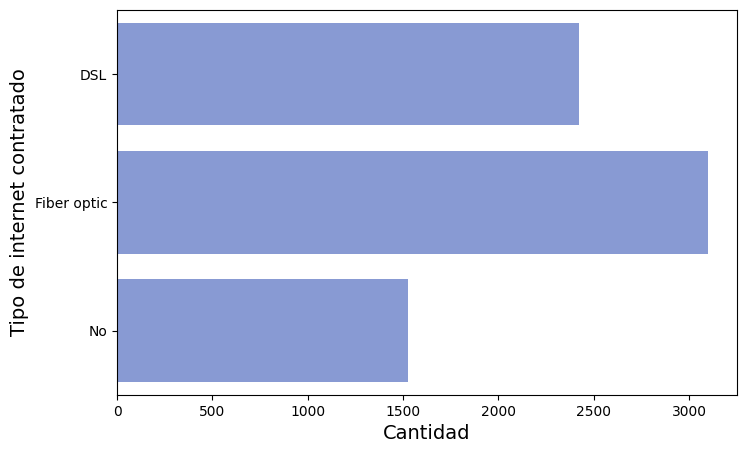

In [7]:
# CountPlot para Tipo de servicio de internet
plt.figure(figsize=(8, 5))
sns.countplot(df['InternetService'], color="#7C93DF")  
plt.xlabel('Cantidad', fontsize=14)
plt.ylabel('Tipo de internet contratado', fontsize=14)

El 44 % de nuestros clientes cuentan con servicio de fibra óptica, seguido por un 35 % que utilizan internet DSL. Por último, un 21 % de los clientes no disponen de servicio de internet en sus hogares.

Text(0, 0.5, 'Método de pago')

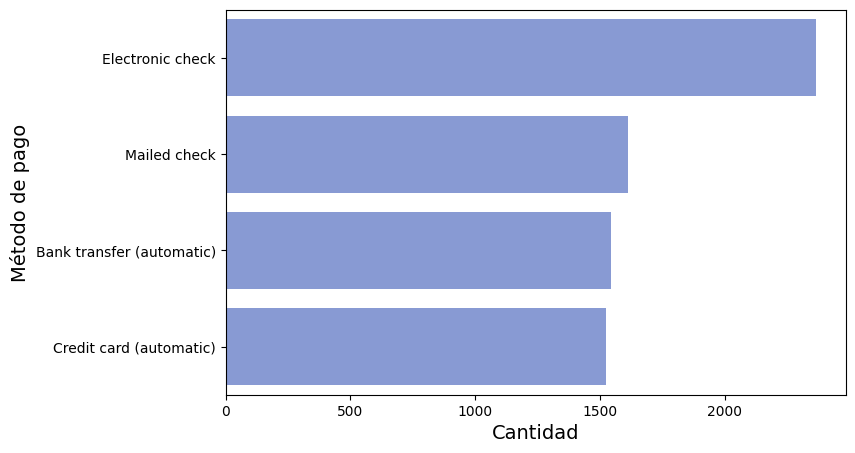

In [8]:
# CountPlot para ver el Método de pago utilizado
plt.figure(figsize=(8, 5))  
sns.countplot(df['PaymentMethod'], color="#7C93DF")  
plt.xlabel('Cantidad', fontsize=14)
plt.ylabel('Método de pago', fontsize=14)

El método de pago más utilizado por los clientes es el cheque electrónico, con una diferencia notable frente a las demás opciones. Le siguen el cheque enviado por correo, la transferencia bancaria automática y la tarjeta de crédito automática, todos con cantidades similares.

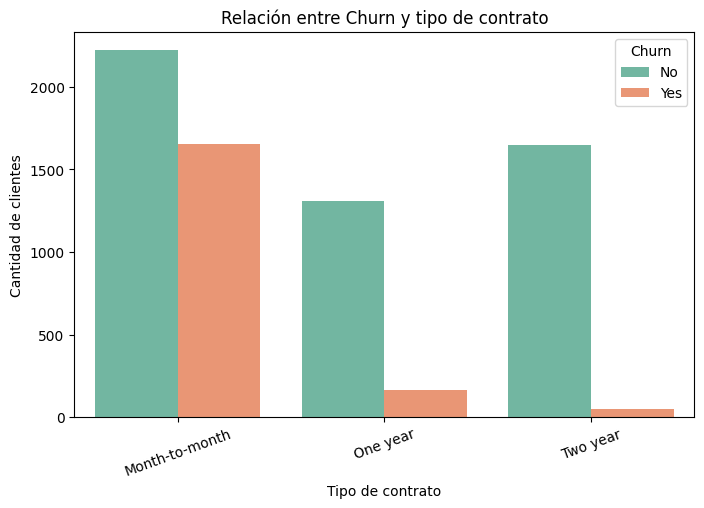

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Contract', hue='Churn', palette='Set2')
plt.title('Relación entre Churn y tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
plt.xticks(rotation=20)
plt.legend(title='Churn')
plt.show()

Los contratos Month-to-month suelen tener más abandonos (Yes), mientras que los de 1 o 2 años tienen menos probabilidad de churn.

In [10]:
# Total mensual perdido por todos los clientes que hicieron churn
monto_mensual_perdido = df[df['Churn'] == 'Yes']['MonthlyCharges'].sum()
print(f"Pérdida mensual total estimada: ${monto_mensual_perdido:.2f}")

Pérdida mensual total estimada: $139130.85


In [11]:
clientes_perdidos = df[df['Churn'] == 'Yes']
estimated_loss = clientes_perdidos['MonthlyCharges'].mean() * 12 * len(clientes_perdidos)

print(f'El abandono actual representa una pérdida anual estimada de USD {len(clientes_perdidos)} millones.')

El abandono actual representa una pérdida anual estimada de USD 1869 millones.


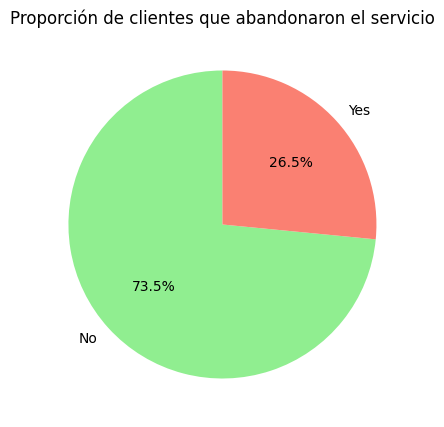

In [12]:
# Grafico de torta para visualizar el porcentaje de clientes que abandonaron o no el servicio en el último mes
plt.figure(figsize=(8, 5))  
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'salmon'], startangle=90)
plt.title('Proporción de clientes que abandonaron el servicio')
plt.ylabel('')
plt.show()

El 26.5% de los clientes abandonaron el servicio en el último mes, en cambio el 73.5% No.

### Heatmap correlaciones con la variable Objetivo 'Churn'.

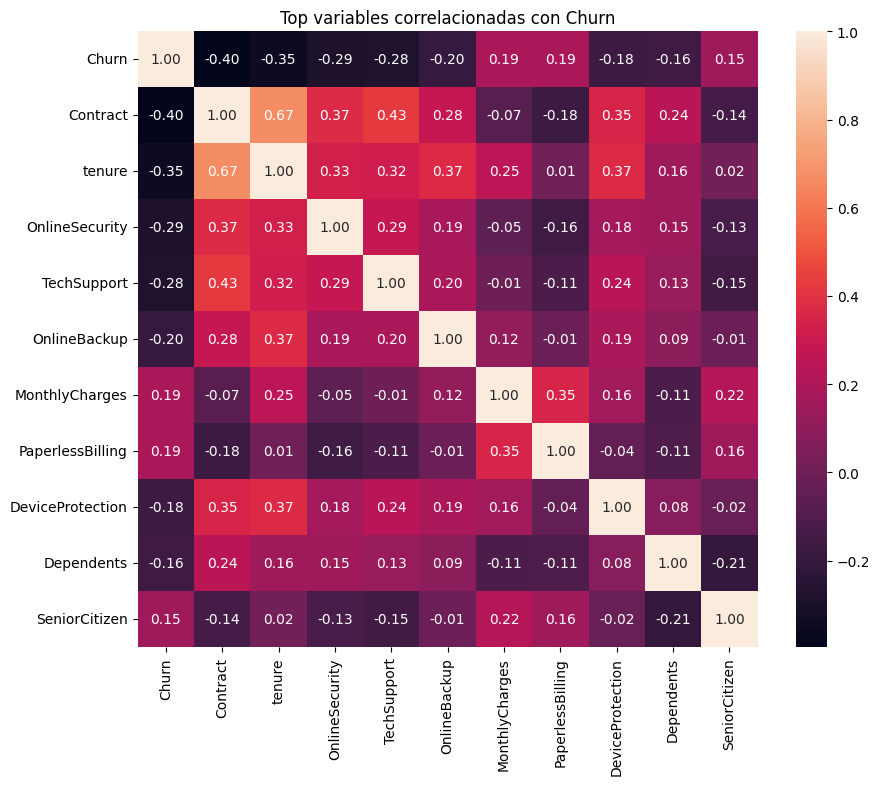

In [13]:
# Copiamos dataset para generar top 10 vars mas correlacionadas con nuestra variable objetivo.
df_heatmap = df.copy()
le = LabelEncoder()
for col in df_heatmap.select_dtypes(include='object'):
    df_heatmap[col] = le.fit_transform(df_heatmap[col])

# Calculamos la matriz de correlación
corr_matrix = df_heatmap.corr()

# Ordenamos las correlaciones absolutas con respecto a Churn
churn_corr = corr_matrix["Churn"].abs().sort_values(ascending=False)

# Seleccionamos las 11 variables más correlacionadas (incluye a "Churn" mismo)
top_corr_features = churn_corr.head(11).index  

# Creamos el heatmap sólo con esas variables
plt.figure(figsize=(10,8))
sns.heatmap(df_heatmap[top_corr_features].corr(), annot=True, fmt=".2f")
plt.title("Top variables correlacionadas con Churn")
plt.show()

### Variable y correlación con 'Churn'.
- tenure	-0.35	Clientes nuevos se dan de baja más que clientes antiguos.
- Contract	-0.40	Contratos largos retienen más al cliente.
- OnlineSecurity	-0.29	Tener seguridad reduce la baja.
- TechSupport	-0.28	Soporte técnico retiene al cliente.
- MonthlyCharges	+0.19	Cargos altos pueden aumentar el abandono.

## Evaluación de riesgo de churn y pérdida económica proyectada

In [14]:
# Aplicamos la regla
df_risk = df.copy()

df_risk['RiesgoChurn'] = df_risk.apply(calcular_riesgo_churn, axis=1)

df_risk['PerdidaProyectada'] = df_risk.apply(perdida_estim, axis=1)

# Vemos clientes con mayor impacto económico
top_clientes = df_risk[df_risk['RiesgoChurn'] != 'Bajo'].sort_values(by='PerdidaProyectada', ascending=False)
top_clientes[['customerID', 'Contract', 'MonthlyCharges', 'RiesgoChurn', 'PerdidaProyectada']].head(10)

prom_perdida_mensual_estimada = top_clientes.PerdidaProyectada.head(10).mean()

print(f'Promedio de perdida mensual estimada en base al top 10 de clientes con mayor riesgo de churn: ${prom_perdida_mensual_estimada} USD')

Promedio de perdida mensual estimada en base al top 10 de clientes con mayor riesgo de churn: $228.76000000000005 USD


Se implementó una regla de negocio sencilla para identificar clientes con contrato mensual y cargos elevados, segmentándolos por riesgo de churn. Esto permite actuar rápidamente sin necesidad de modelos complejos, y proyectar pérdidas potenciales para priorizar intervenciones.

## Preprocesamiento

In [15]:
# Dropeamos columna 'customerID'
df = df.drop('customerID', axis = 1)

In [16]:
# Relizamos LabelEncoder para transformar columnas que tengan solo 2 valores a un resultado binario (0/1)
le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])  # 'Female' -> 0, 'Male' -> 1

In [17]:
# Convertir columnas Yes/No a 1/0 con Pandas
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [18]:
# Lista de columnas a codificar con One Hot Encoding
cols_to_encode = ["MultipleLines", "InternetService", "Contract", "PaymentMethod"]

# Aplicamos One Hot Encoding solo a esas columnas
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

In [19]:
# Convierte todas las columnas booleanas a 1 y 0
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

In [20]:
# # Convertimos columna 'TotalCharges' a numerico
df.TotalCharges = df.TotalCharges.str.strip()
df.TotalCharges = df.TotalCharges.str.replace(12345, '') # Reemplazamos valores vacios por nulos
df = df[df.TotalCharges != 12345] # Dropeamnos filas que contengan algún valor nulo

df.TotalCharges = df.TotalCharges.astype('float')

## Modelado

In [21]:
# Separamos en X e y
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
# Generamos la grilla para encontrar mejor combinación de hiperparametros
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Mejores parámetros:", best_params)

# Entrenamos el modelo final con los mejores parámetros
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [23]:
# Evaluamos el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1282
           1       0.69      0.50      0.58       479

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.73      1761
weighted avg       0.79      0.80      0.79      1761

[[1175  107]
 [ 238  241]]
ROC AUC Score: 0.8594632929367279


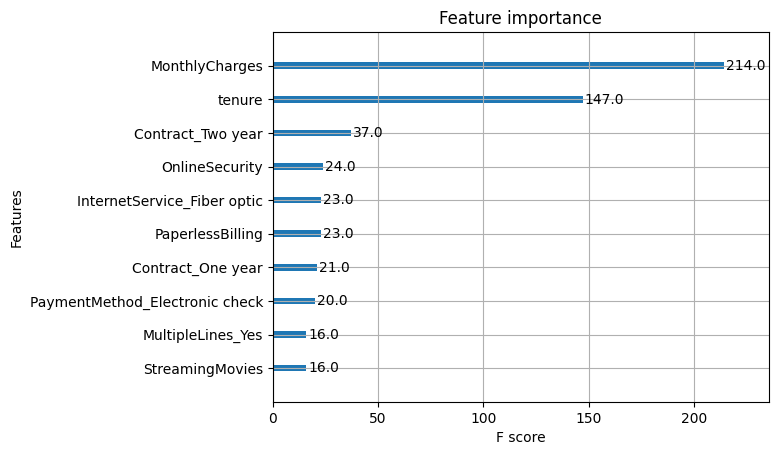

In [24]:
# Feature importance
plot_importance(model, max_num_features=10)
plt.show()

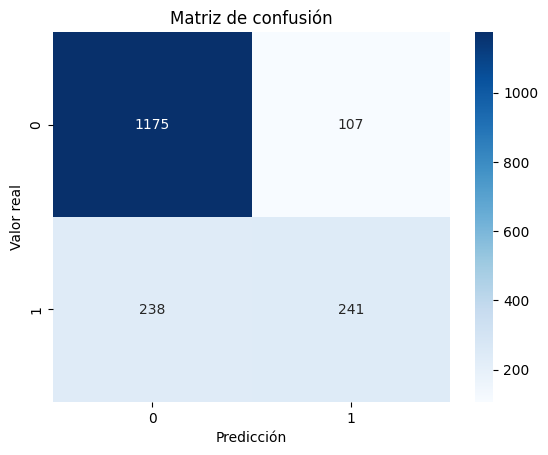

In [25]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.show()

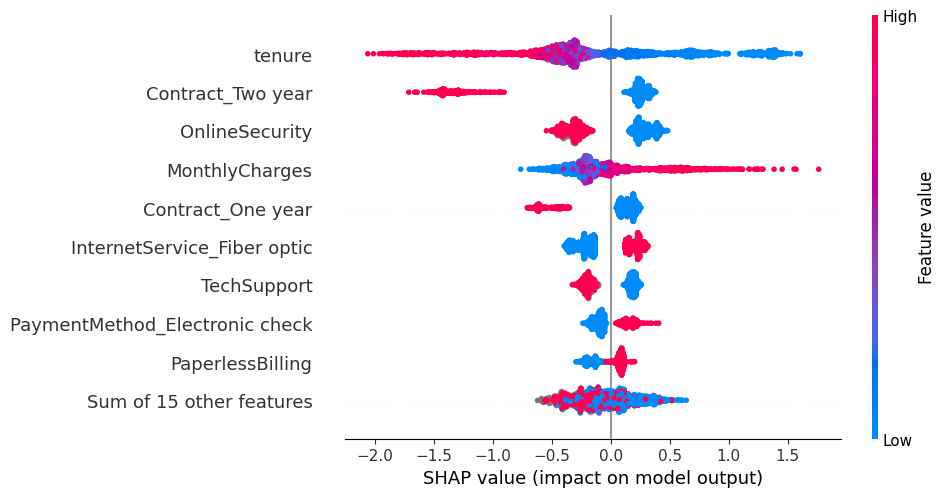

In [26]:
# INTERPRETABILIDAD SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

### Resultados SHAP

#### Eje horizontal
- Representa los valores SHAP, que indican cuánto cada característica aumenta o disminuye la predicción del modelo.
- **Valores positivos** (hacia la derecha) aumentan la probabilidad del resultado predicho.
- **Valores negativos** (hacia la izquierda) disminuyen la probabilidad del resultado predicho.

#### Características
- Las características están listadas en el eje vertical, como `tenure`, `Contract_Two year`, `MonthlyCharges`, etc.
- Cada una tiene un impacto en la predicción del modelo.

#### Color
- El color indica el valor de la característica:
  - **Rojo**: Valores altos para esa característica.
  - **Azul**: Valores bajos para esa característica.

#### Interpretación
- Contract (negativo)	⬇️	Tener un contrato de 1 o 2 años reduce el riesgo de baja (da estabilidad al cliente).
- MonthlyCharges (positivo)	⬆️	Cargos mensuales altos aumentan el riesgo: clientes pueden percibir el servicio como caro.
- tenure (negativo)	⬇️	Clientes nuevos tienden a abandonar más que los antiguos. Fidelización es clave.
---

## Conclusiones del Análisis

###  Principales factores asociados al churn:
- **Contract (-0.40)**: Los clientes con contratos mensuales tienen mucha mayor probabilidad de abandonar que aquellos con contratos anuales o bianuales.
- **Tenure (-0.35)**: Los clientes nuevos (poca antigüedad) son más propensos al churn que los clientes leales de largo plazo.
- **OnlineSecurity (-0.29)**: Los clientes sin servicios de seguridad online tienen mayor tasa de abandono.

Estas variables permiten construir perfiles de riesgo y orientar estrategias de fidelización.

###  Impacto Económico Estimado:
- El total estimado de pérdida mensual por clientes que hicieron churn supera los **$139,130.85 USD**.
- Entre los 10 clientes con mayor riesgo, la pérdida mensual proyectada promedio es de **$228.76 USD**.

###  Modelo:
- Rendimiento General: El modelo es capaz de predecir con un 86% de precisión si un cliente hará churn o no (métrica ROC AUC). Esto demuestra que es una herramienta prometedora para la detección temprana.
- Área de Mejora Crítica: El modelo solo identifica al 50% de los clientes que realmente abandonan (Recall = 0.50). Esto significa que, actualmente, el modelo no anticipa la mitad de las posibles pérdidas de clientes.

###  Recomendaciones Estratégicas para reducir el churn y optimizar costos:
1. **Incentivar contratos a largo plazo**, ofreciendo descuentos o beneficios exclusivos al migrar de contrato mensual a anual.
2. **Ofrecer servicios de seguridad online como parte de promociones** para reforzar la fidelización.
3. **Enfocar campañas preventivas en clientes nuevos con alta facturación**, ya que son los más vulnerables a abandonar.
4. **Utilizar dashboards en Power BI** que muestren clientes en riesgo y pérdida potencial en tiempo real, para facilitar la toma de decisiones desde Finanzas.

---